In [ ]:
import requests
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from sqlalchemy import create_engine

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds"

In [ ]:
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()

In [ ]:
resp = requests.get(url, headers=headers)
resp.raise_for_status()
html = resp.text

In [ ]:
tables = pd.read_html(html)
print("Number of tables found:", len(tables))
for i, t in enumerate(tables):
    print(i, t.shape, list(t.columns)[:6])

Number of tables found: 9
0 (1, 2) [0, 1]
1 (51, 15) [('Country (or territory)', 'Country (or territory)'), ('Region', 'Region'), ('Hospital beds per 1,000 people[6]', '2013'), ('Hospital beds per 1,000 people[6]', '2014'), ('Hospital beds per 1,000 people[6]', '2015'), ('Hospital beds per 1,000 people[6]', '2016')]
2 (6, 2) ['vteLists of countries by quality of life rankings', 'vteLists of countries by quality of life rankings.1']
3 (3, 2) ['vteList of hospitals in Africa', 'vteList of hospitals in Africa.1']
4 (4, 2) ['vteList of hospitals in Asia', 'vteList of hospitals in Asia.1']
5 (3, 2) ['vteList of hospitals in Europe', 'vteList of hospitals in Europe.1']
6 (2, 2) ['vteList of hospitals in North America', 'vteList of hospitals in North America.1']
7 (3, 2) ['vteList of hospitals in Oceania', 'vteList of hospitals in Oceania.1']
8 (2, 2) ['vteList of hospitals in South America', 'vteList of hospitals in South America.1']


/tmp/ipython-input-3492461521.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


In [ ]:
table_index = None
for i, t in enumerate(tables):
    cols_joined = " ".join([str(c) for c in t.columns])
    if re.search(r"Hospital beds|Hospital beds per|beds per 1000|beds per 1,000", cols_joined, flags=re.I):
        table_index = i
        break

In [ ]:
if table_index is None:
    table_index = max(range(len(tables)), key=lambda i: tables[i].shape[0])
print("Using table index:", table_index)

raw_df = tables[table_index].copy()
print("Raw table shape:", raw_df.shape)
display(raw_df.head(3))

Using table index: 1
Raw table shape: (51, 15)


Country (or territory) Region Hospital beds per 1,000 people[6]         \
  Country (or territory) Region                              2013   2014   
0      DPRK(North Korea)    NaN                             13.20   13.2   
1                Belarus    NaN                              10.2   10.1   
2            South Korea   Asia                             10.92  11.59   

                                                         Occupancy (%)[7]  \
    2015   2016   2017   2018   2019   2020   2021  2022 Occupancy (%)[7]   
0   13.2   13.2   13.2   13.2   13.2   13.2   13.2  13.2              NaN   
1     10    9.8    9.8    9.7    9.7    NaN    NaN   NaN              NaN   
2  11.61  11.99  12.29  12.44  12.43  12.65  12.77     —                —   

  ICU-CCB beds /100,000 inhabitants Ventilators  
  ICU-CCB beds /100,000 inhabitants Ventilators  
0                               NaN         NaN  
1                            866.42         NaN  
2                         [8] 10.60   [9] 9,795

In [ ]:
if isinstance(raw_df.columns, pd.MultiIndex):
    raw_df.columns = [" | ".join([str(c).strip() for c in col if str(c).strip()]) for col in raw_df.columns.values]
else:
    raw_df.columns = [str(c).strip() for c in raw_df.columns]

In [ ]:
def clean_col(col):
    col = re.sub(r"\[[^\]]*\]", "", col)            # remove [1] references
    col = re.sub(r"\s+", " ", col).strip()         # normalize whitespace
    return col

In [ ]:
raw_df.columns = [clean_col(c) for c in raw_df.columns]
print("Columns after cleaning:", raw_df.columns.tolist())

Columns after cleaning: ['Country (or territory) | Country (or territory)', 'Region | Region', 'Hospital beds per 1,000 people | 2013', 'Hospital beds per 1,000 people | 2014', 'Hospital beds per 1,000 people | 2015', 'Hospital beds per 1,000 people | 2016', 'Hospital beds per 1,000 people | 2017', 'Hospital beds per 1,000 people | 2018', 'Hospital beds per 1,000 people | 2019', 'Hospital beds per 1,000 people | 2020', 'Hospital beds per 1,000 people | 2021', 'Hospital beds per 1,000 people | 2022', 'Occupancy (%) | Occupancy (%)', 'ICU-CCB beds /100,000 inhabitants | ICU-CCB beds /100,000 inhabitants', 'Ventilators | Ventilators']


In [ ]:
cols = raw_df.columns.tolist()

In [ ]:
country_col = None
for candidate in ["Country (or territory)", "Country", "State", "country", "Country (or territory) [note]"]:
    if candidate in cols:
        country_col = candidate
        break

In [ ]:
if country_col is None:
    for c in cols:
        if re.search(r"country", c, flags=re.I):
            country_col = c
            break

In [ ]:
year_cols = [c for c in cols if re.match(r"^(19|20)\d{2}$", str(c).strip())]
print("Detected year columns:", year_cols)
print("Detected country column:", country_col)

Detected year columns: []
Detected country column: Country (or territory) | Country (or territory)


In [ ]:
if not year_cols:
    # sometimes headers are like '2013 2014 2015' combined in one string; split by whitespace and detect
    candidate = None
    for c in cols:
        tokens = re.findall(r"(19|20)\d{2}", c)
        if tokens:
            candidate = c
            break
    if candidate:
        # expand: try to split candidate by whitespace into multiple year headers (only when read_html made them one column)
        print("Found embedded year header column:", candidate)
        # fallback - we'll treat the rest of numeric columns after country as year-like
        numeric_like = [c for c in cols if re.match(r"^[\d\.,\s]+$", str(raw_df[c].astype(str).iloc[0])) or re.match(r"^(19|20)\d{2}$", c)]
        print("Numeric-like columns guessed as years:", numeric_like)
        year_cols = numeric_like

Found embedded year header column: Hospital beds per 1,000 people | 2013
Numeric-like columns guessed as years: ['Hospital beds per 1,000 people | 2013', 'Hospital beds per 1,000 people | 2014', 'Hospital beds per 1,000 people | 2015', 'Hospital beds per 1,000 people | 2016', 'Hospital beds per 1,000 people | 2017', 'Hospital beds per 1,000 people | 2018', 'Hospital beds per 1,000 people | 2019', 'Hospital beds per 1,000 people | 2020', 'Hospital beds per 1,000 people | 2021', 'Hospital beds per 1,000 people | 2022']


In [ ]:
if not year_cols:
    # As final fallback: choose columns whose header contains a 4-digit year or whose values look numeric across many rows
    possible_years = []
    for c in cols:
        if re.search(r"(19|20)\d{2}", c):
            possible_years.append(c)
    if not possible_years:
        # take columns 1..10 as candidate year columns if table structure matches (country first then years)
        possible_years = cols[1:1+10]
    year_cols = possible_years

print("Final year columns used:", year_cols)

Final year columns used: ['Hospital beds per 1,000 people | 2013', 'Hospital beds per 1,000 people | 2014', 'Hospital beds per 1,000 people | 2015', 'Hospital beds per 1,000 people | 2016', 'Hospital beds per 1,000 people | 2017', 'Hospital beds per 1,000 people | 2018', 'Hospital beds per 1,000 people | 2019', 'Hospital beds per 1,000 people | 2020', 'Hospital beds per 1,000 people | 2021', 'Hospital beds per 1,000 people | 2022']


In [ ]:
keep_cols = [c for c in [country_col, 'Region'] if c in raw_df.columns] + year_cols
# also include any columns containing 'Occupancy' or 'ICU' or 'Ventilator'
for c in raw_df.columns:
    if re.search(r"Occupanc|ICU|Ventilator|beds per 1000|per 1,000", c, flags=re.I):
        if c not in keep_cols:
            keep_cols.append(c)

print("Columns to keep:", keep_cols)
df = raw_df[keep_cols].copy()

Columns to keep: ['Country (or territory) | Country (or territory)', 'Hospital beds per 1,000 people | 2013', 'Hospital beds per 1,000 people | 2014', 'Hospital beds per 1,000 people | 2015', 'Hospital beds per 1,000 people | 2016', 'Hospital beds per 1,000 people | 2017', 'Hospital beds per 1,000 people | 2018', 'Hospital beds per 1,000 people | 2019', 'Hospital beds per 1,000 people | 2020', 'Hospital beds per 1,000 people | 2021', 'Hospital beds per 1,000 people | 2022', 'Occupancy (%) | Occupancy (%)', 'ICU-CCB beds /100,000 inhabitants | ICU-CCB beds /100,000 inhabitants', 'Ventilators | Ventilators']


In [ ]:
def to_numeric_col(s):
    return s.astype(str).str.replace(r"\[.*?\]", "", regex=True).str.replace(",", "", regex=False).str.strip().replace("", np.nan)

for yc in year_cols:
    if yc in df.columns:
        df[yc] = to_numeric_col(df[yc]).replace("–", np.nan).replace("—", np.nan)
        # now coerce to float
        df[yc] = pd.to_numeric(df[yc], errors='coerce')

In [ ]:
df = df.rename(columns={country_col: 'country'})

In [ ]:
if year_cols:
    df_long = df.melt(id_vars=[c for c in df.columns if c not in year_cols],
                      value_vars=year_cols,
                      var_name='year',
                      value_name='beds_per_1000')
    # clean year column (if it's string like '2013'):
    df_long['year'] = df_long['year'].astype(str).str.extract(r"((?:19|20)\d{2})", expand=False).astype(float)
    df_long = df_long.sort_values(['country','year']).reset_index(drop=True)
    print("Long format shape:", df_long.shape)
    display(df_long.head(8))
else:
    df_long = df.copy()

Long format shape: (510, 6)


,country,Occupancy (%) | Occupancy (%),"ICU-CCB beds /100,000 inhabitants | ICU-CCB beds /100,000 inhabitants",Ventilators | Ventilators,year,beds_per_1000
0,Argentina [failed verification],—,—,—,2013.0,NaN
1,Argentina [failed verification],—,—,—,2014.0,NaN
2,Argentina [failed verification],—,—,—,2015.0,NaN
3,Argentina [failed verification],—,—,—,2016.0,NaN
4,Argentina [failed verification],—,—,—,2017.0,5.0
5,Argentina [failed verification],—,—,—,2018.0,NaN
6,Argentina [failed verification],—,—,—,2019.0,NaN
7,Argentina [failed verification],—,—,—,2020.0,NaN


In [ ]:
df_long.to_csv("hospital_beds_cleaned_long.csv", index=False)
df.to_csv("hospital_beds_wide_cleaned.csv", index=False)
print("Saved hospital_beds_cleaned_long.csv and hospital_beds_wide_cleaned.csv")

Saved hospital_beds_cleaned_long.csv and hospital_beds_wide_cleaned.csv


In [ ]:
engine = create_engine("sqlite:///hospital_beds.db")
df_long.to_sql("hospital_beds", engine, if_exists="replace", index=False)
print("Loaded cleaned data into SQLite database hospital_beds.db (table: hospital_beds)")

Loaded cleaned data into SQLite database hospital_beds.db (table: hospital_beds)


In [ ]:
q = "SELECT country, year, beds_per_1000 FROM hospital_beds WHERE beds_per_1000 IS NOT NULL ORDER BY beds_per_1000 DESC LIMIT 10;"
top10 = pd.read_sql_query(q, engine)
display(top10)

,country,year,beds_per_1000
0,Japan,2013.0,13.30
1,Japan,2014.0,13.21
2,DPRK(North Korea),2013.0,13.20
3,DPRK(North Korea),2014.0,13.20
4,DPRK(North Korea),2015.0,13.20
5,DPRK(North Korea),2016.0,13.20
6,DPRK(North Korea),2017.0,13.20
7,DPRK(North Korea),2018.0,13.20
8,DPRK(North Korea),2019.0,13.20
9,DPRK(North Korea),2020.0,13.20


In [ ]:
df

,country,"Hospital beds per 1,000 people | 2013","Hospital beds per 1,000 people | 2014","Hospital beds per 1,000 people | 2015","Hospital beds per 1,000 people | 2016","Hospital beds per 1,000 people | 2017","Hospital beds per 1,000 people | 2018","Hospital beds per 1,000 people | 2019","Hospital beds per 1,000 people | 2020","Hospital beds per 1,000 people | 2021","Hospital beds per 1,000 people | 2022",Occupancy (%) | Occupancy (%),"ICU-CCB beds /100,000 inhabitants | ICU-CCB beds /100,000 inhabitants",Ventilators | Ventilators
0,DPRK(North Korea),13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,NaN,NaN,NaN
1,Belarus,10.20,10.10,10.00,9.80,9.80,9.70,9.70,NaN,NaN,NaN,NaN,866.42,NaN
2,South Korea,10.92,11.59,11.61,11.99,12.29,12.44,12.43,12.65,12.77,NaN,—,[8] 10.60,"[9] 9,795"
3,Japan,13.30,13.21,13.17,13.11,13.05,12.98,12.84,12.63,12.62,12.40,75.50,[10] 13.50,"[11] 45,293"
4,Ukraine [failed verification],NaN,NaN,NaN,NaN,8.80,NaN,NaN,NaN,NaN,NaN,—,—,"[12] 3,600"
5,Russia,9.07,8.81,8.35,8.16,8.05,7.99,8.00,NaN,NaN,NaN,—,[13] 8.30,"[12] 40,000 (27.3 per 100,000 inhabitants)"
6,Bulgaria,6.82,7.13,7.24,7.27,7.45,7.57,7.74,7.82,7.92,NaN,—,—,—
7,Germany,8.28,8.23,8.13,8.06,8.00,7.98,7.91,7.82,7.76,NaN,[14] 62.10,[14] 38.70,"[15] 25,000"
8,Romania,6.67,6.71,6.79,6.84,6.89,6.97,7.06,7.12,7.21,NaN,—,—,—
9,Austria,7.64,7.58,7.54,7.42,7.37,7.27,7.19,7.05,6.91,NaN,73.80,[16] 21.80,"[17] 2,500"


In [ ]:
df.info()
df.describe()
df.isna().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 14 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   country                                                                51 non-null     object 
 1   Hospital beds per 1,000 people | 2013                                  49 non-null     float64
 2   Hospital beds per 1,000 people | 2014                                  48 non-null     float64
 3   Hospital beds per 1,000 people | 2015                                  48 non-null     float64
 4   Hospital beds per 1,000 people | 2016                                  48 non-null     float64
 5   Hospital beds per 1,000 people | 2017                                  50 non-null     float64
 6   Hospital beds per 1,000 people | 2018                                  45 non-null     float

np.int64(0)

In [ ]:
latest_year = df_long['year'].max()
latest = df_long[df_long['year'] == latest_year].dropna(subset=['beds_per_1000'])

top10 = latest.sort_values('beds_per_1000', ascending=False).head(10)
bottom10 = latest.sort_values('beds_per_1000', ascending=True).head(10)

print("Top 10 countries by beds per 1000 in", int(latest_year))
display(top10[['country', 'beds_per_1000']])

print("\nBottom 10 countries by beds per 1000 in", int(latest_year))
display(bottom10[['country', 'beds_per_1000']])


Top 10 countries by beds per 1000 in 2022


,country,beds_per_1000
149,DPRK(North Korea),13.20
299,Japan,12.40
99,China,8.37
49,Belgium,5.47
509,United States,3.00
279,Israel,2.99
359,New Zealand,2.57
499,United Kingdom,2.44
89,Chile,1.93
119,Costa Rica,1.11



Bottom 10 countries by beds per 1000 in 2022


,country,beds_per_1000
119,Costa Rica,1.11
89,Chile,1.93
499,United Kingdom,2.44
359,New Zealand,2.57
279,Israel,2.99
509,United States,3.00
49,Belgium,5.47
99,China,8.37
299,Japan,12.40
149,DPRK(North Korea),13.20


In [ ]:
if 'Region' in df.columns:
    df.groupby('Region')['beds_per_1000'].mean().sort_values(ascending=False)


In [ ]:
df

,country,"Hospital beds per 1,000 people | 2013","Hospital beds per 1,000 people | 2014","Hospital beds per 1,000 people | 2015","Hospital beds per 1,000 people | 2016","Hospital beds per 1,000 people | 2017","Hospital beds per 1,000 people | 2018","Hospital beds per 1,000 people | 2019","Hospital beds per 1,000 people | 2020","Hospital beds per 1,000 people | 2021","Hospital beds per 1,000 people | 2022",Occupancy (%) | Occupancy (%),"ICU-CCB beds /100,000 inhabitants | ICU-CCB beds /100,000 inhabitants",Ventilators | Ventilators
0,DPRK(North Korea),13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,13.20,NaN,NaN,NaN
1,Belarus,10.20,10.10,10.00,9.80,9.80,9.70,9.70,NaN,NaN,NaN,NaN,866.42,NaN
2,South Korea,10.92,11.59,11.61,11.99,12.29,12.44,12.43,12.65,12.77,NaN,—,[8] 10.60,"[9] 9,795"
3,Japan,13.30,13.21,13.17,13.11,13.05,12.98,12.84,12.63,12.62,12.40,75.50,[10] 13.50,"[11] 45,293"
4,Ukraine [failed verification],NaN,NaN,NaN,NaN,8.80,NaN,NaN,NaN,NaN,NaN,—,—,"[12] 3,600"
5,Russia,9.07,8.81,8.35,8.16,8.05,7.99,8.00,NaN,NaN,NaN,—,[13] 8.30,"[12] 40,000 (27.3 per 100,000 inhabitants)"
6,Bulgaria,6.82,7.13,7.24,7.27,7.45,7.57,7.74,7.82,7.92,NaN,—,—,—
7,Germany,8.28,8.23,8.13,8.06,8.00,7.98,7.91,7.82,7.76,NaN,[14] 62.10,[14] 38.70,"[15] 25,000"
8,Romania,6.67,6.71,6.79,6.84,6.89,6.97,7.06,7.12,7.21,NaN,—,—,—
9,Austria,7.64,7.58,7.54,7.42,7.37,7.27,7.19,7.05,6.91,NaN,73.80,[16] 21.80,"[17] 2,500"


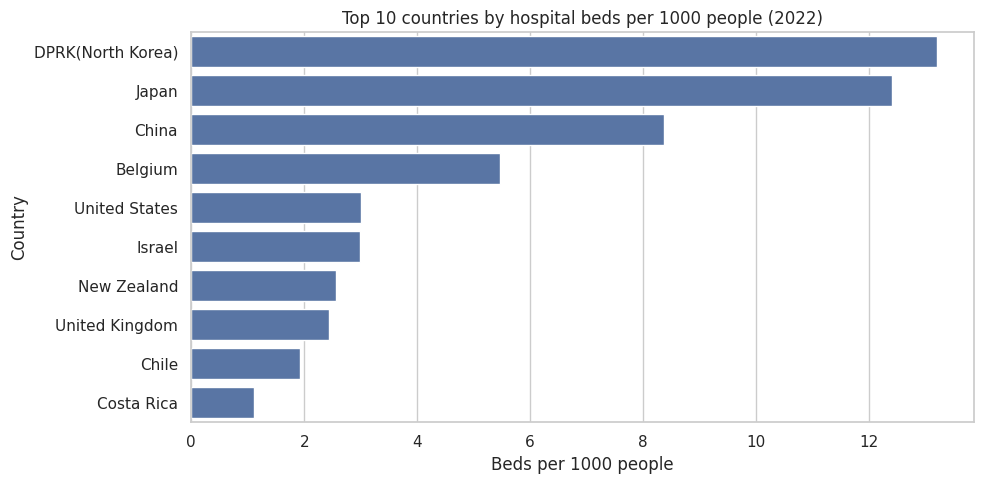

In [ ]:
plt.figure()
sns.barplot(data=top10, x='beds_per_1000', y='country')
plt.title(f"Top 10 countries by hospital beds per 1000 people ({int(latest_year)})")
plt.xlabel("Beds per 1000 people")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


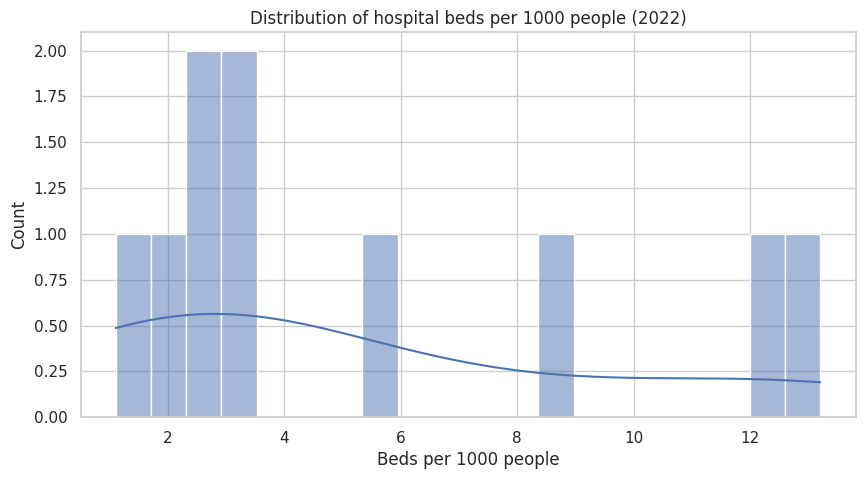

In [ ]:
plt.figure()
sns.histplot(latest['beds_per_1000'].dropna(), bins=20, kde=True)
plt.title(f"Distribution of hospital beds per 1000 people ({int(latest_year)})")
plt.xlabel("Beds per 1000 people")
plt.show()


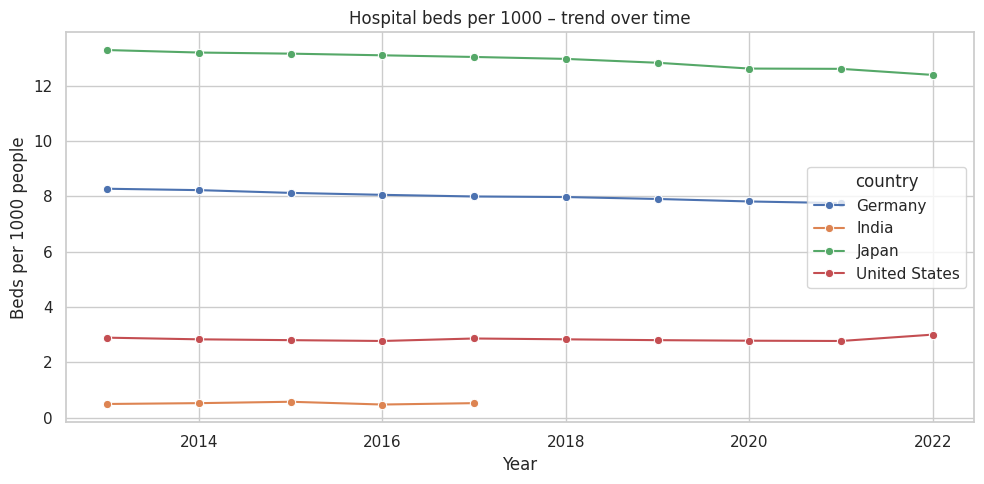

In [ ]:
countries_to_plot = ['Japan', 'Germany', 'India', 'United States']  # change as available
subset = df_long[df_long['country'].isin(countries_to_plot)]

plt.figure()
sns.lineplot(data=subset, x='year', y='beds_per_1000', hue='country', marker="o")
plt.title("Hospital beds per 1000 – trend over time")
plt.ylabel("Beds per 1000 people")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


### **SQL**

In [ ]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///hospital_beds.db")


In [ ]:
pd.read_sql_query("PRAGMA table_info(hospital_beds);", engine)


,cid,name,type,notnull,dflt_value,pk
0,0,country,TEXT,0,None,0
1,1,Occupancy (%) | Occupancy (%),TEXT,0,None,0
2,2,"ICU-CCB beds /100,000 inhabitants | ICU-CCB be...",TEXT,0,None,0
3,3,Ventilators | Ventilators,TEXT,0,None,0
4,4,year,FLOAT,0,None,0
5,5,beds_per_1000,FLOAT,0,None,0


In [ ]:
pd.read_sql_query("""
SELECT country, year, beds_per_1000
FROM hospital_beds
WHERE beds_per_1000 IS NOT NULL
ORDER BY beds_per_1000 DESC
LIMIT 10;
""", engine)


,country,year,beds_per_1000
0,Japan,2013.0,13.30
1,Japan,2014.0,13.21
2,DPRK(North Korea),2013.0,13.20
3,DPRK(North Korea),2014.0,13.20
4,DPRK(North Korea),2015.0,13.20
5,DPRK(North Korea),2016.0,13.20
6,DPRK(North Korea),2017.0,13.20
7,DPRK(North Korea),2018.0,13.20
8,DPRK(North Korea),2019.0,13.20
9,DPRK(North Korea),2020.0,13.20


In [ ]:
pd.read_sql_query("""
SELECT year, AVG(beds_per_1000) AS avg_beds
FROM hospital_beds
WHERE beds_per_1000 IS NOT NULL
GROUP BY year
ORDER BY year;
""", engine)


,year,avg_beds
0,2013.0,4.896122
1,2014.0,4.916875
2,2015.0,4.883958
3,2016.0,4.796458
4,2017.0,4.899600
5,2018.0,4.950222
6,2019.0,4.915778
7,2020.0,4.694419
8,2021.0,4.818537
9,2022.0,5.348000


In [ ]:
pd.read_sql_query("""
SELECT country,
       MIN(beds_per_1000) AS min_beds,
       MAX(beds_per_1000) AS max_beds
FROM hospital_beds
GROUP BY country
ORDER BY max_beds - min_beds DESC
LIMIT 10;
""", engine)


,country,min_beds,max_beds
0,China,3.33,8.37
1,Finland,2.75,4.86
2,South Korea,10.92,12.77
3,Lithuania,6.01,7.31
4,Bulgaria,6.82,7.92
5,Russia,7.99,9.07
6,Luxembourg,4.14,5.17
7,Japan,12.40,13.30
8,Netherlands,2.91,3.69
9,Austria,6.91,7.64


In [ ]:
pd.read_sql_query("""
SELECT country, beds_per_1000
FROM hospital_beds
WHERE year = 2021
ORDER BY beds_per_1000 DESC
LIMIT 1;
""", engine)

,country,beds_per_1000
0,DPRK(North Korea),13.2


In [ ]:
pd.read_sql_query("""
SELECT country, AVG(beds_per_1000) AS average_beds_per_1000
FROM hospital_beds
WHERE beds_per_1000 IS NOT NULL
GROUP BY country
ORDER BY average_beds_per_1000 DESC
LIMIT 10;
""", engine)

,country,average_beds_per_1000
0,DPRK(North Korea),13.200000
1,Japan,12.931000
2,South Korea,12.076667
3,Belarus,9.900000
4,Ukraine [failed verification],8.800000
5,Russia,8.347143
6,Germany,8.018889
7,Bulgaria,7.440000
8,Austria,7.330000
9,Hungary,6.937778


In [ ]:
pd.read_sql_query("""
SELECT country, COUNT(beds_per_1000) AS data_points_available
FROM hospital_beds
GROUP BY country
ORDER BY data_points_available DESC;
""", engine)

,country,data_points_available
0,United States,10
1,United Kingdom,10
2,New Zealand,10
3,Japan,10
4,Israel,10
5,DPRK(North Korea),10
6,Costa Rica,10
7,China,10
8,Chile,10
9,Belgium,10


In [ ]:
pd.read_sql_query("""
WITH RankedBeds AS (
    SELECT
        country,
        year,
        beds_per_1000,
        ROW_NUMBER() OVER(PARTITION BY country ORDER BY year ASC) as rn_asc,
        ROW_NUMBER() OVER(PARTITION BY country ORDER BY year DESC) as rn_desc
    FROM hospital_beds
    WHERE beds_per_1000 IS NOT NULL
)
SELECT
    t1.country,
    t1.year AS first_year,
    t1.beds_per_1000 AS first_beds,
    t2.year AS last_year,
    t2.beds_per_1000 AS last_beds,
    (t2.beds_per_1000 - t1.beds_per_1000) AS bed_change
FROM RankedBeds t1
JOIN RankedBeds t2
ON t1.country = t2.country
WHERE t1.rn_asc = 1 AND t2.rn_desc = 1 AND t1.year != t2.year
ORDER BY bed_change DESC
LIMIT 10;
""", engine)

,country,first_year,first_beds,last_year,last_beds,bed_change
0,China,2013.0,3.33,2022.0,8.37,5.04
1,South Korea,2013.0,10.92,2021.0,12.77,1.85
2,Bulgaria,2013.0,6.82,2021.0,7.92,1.10
3,Romania,2013.0,6.67,2021.0,7.21,0.54
4,Turkey,2013.0,2.65,2021.0,3.02,0.37
5,Ireland,2013.0,2.56,2021.0,2.89,0.33
6,Colombia,2013.0,1.55,2020.0,1.69,0.14
7,Portugal,2013.0,3.39,2021.0,3.50,0.11
8,United States,2013.0,2.89,2022.0,3.00,0.11
9,Australia,2013.0,3.74,2016.0,3.84,0.10
